# Location regression with only smooth terms

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

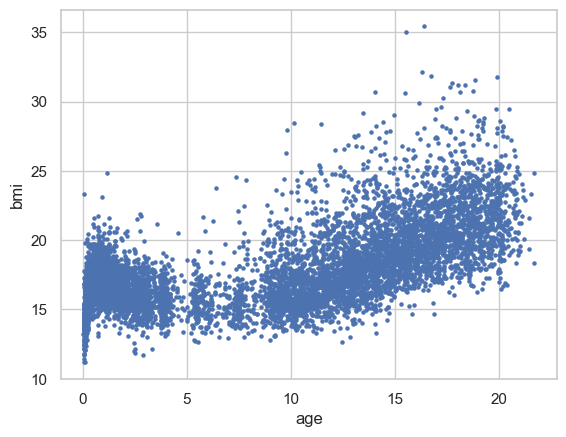

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [3]:
# Standardize response 
# Could be an idea to standardize the response for numerical stability 
y_test = (df["bmi"].to_numpy() - df["bmi"].to_numpy().mean())/df["bmi"].to_numpy().std()

In [4]:
# Set up design matrix 
X = tiger.Obs(name="X_loc", intercept=False)
X.smooth(data=df["age"].to_numpy(), n_knots=25)

# Set up hyperparameters for the beta_scale  
tau_a = tiger.Hyper(1.0, name="tau_a")
tau_b = tiger.Hyper(0.005, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=1.0, distribution=tau_dist, param_space="positive", name="tau")

# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(jnp.zeros(X.smooth_dim[0]), name="beta_smooth_loc")

# Define the penaly matrix from class Obs
pen = X.smooth_pen_mat[0]

# Set up parameters 
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=jnp.repeat(df["bmi"].to_numpy().mean(), X.smooth_dim[0]), distribution=beta_smooth_dist, name="beta_smooth")

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up the linear predictor 
lpred = tiger.Lpred(obs=X, beta_smooth=beta_smooth)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [5]:
m.log_prob

Array(-23834.254, dtype=float32)

In [6]:
m.log_prior 

Array(-28.2165, dtype=float32)

In [7]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [8]:
graph.logprob()

Array(-23834.254, dtype=float32)

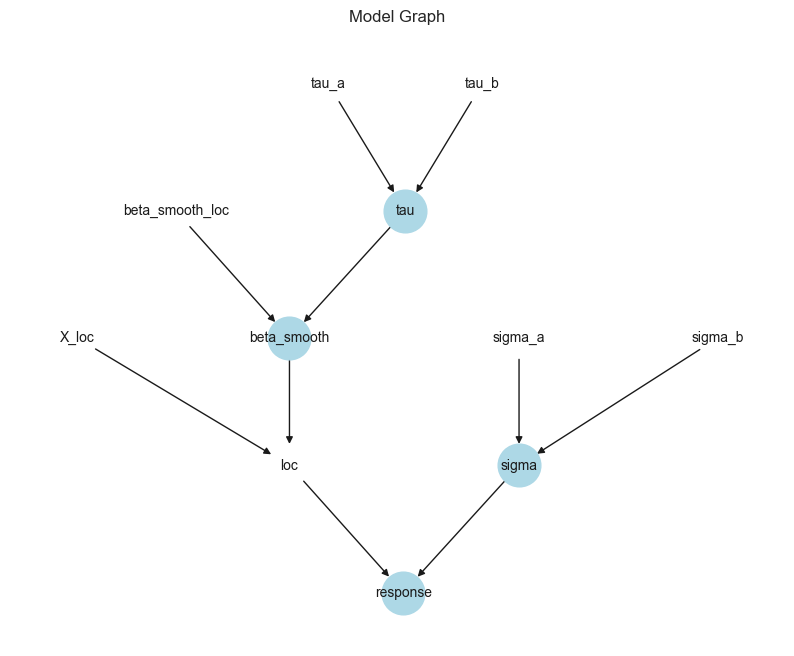

In [9]:
graph.visualize_graph()

## Test functions of Bbvi

In [25]:
import tigerpy.distributions.mvn as mvn
q = bbvi.Bbvi(graph=graph)
key = jax.random.PRNGKey(27)
key, *subkeys = jax.random.split(key, len(q.init_variational_params)+1)

AttributeError: 'Bbvi' object has no attribute 'init_variational_params'

In [18]:
loc_beta_smooth, lower_tri_beta_smooth = q.init_variational_params["beta_smooth"]["loc"], q.init_variational_params["beta_smooth"]["lower_tri"]
loc_sigma, lower_tri_sigma = q.init_variational_params["sigma"]["loc"], q.init_variational_params["sigma"]["lower_tri"]
loc_tau, lower_tri_tau= q.init_variational_params["tau"]["loc"], q.init_variational_params["tau"]["lower_tri"]

In [19]:
samples_beta_smooth = mvn.mvn_precision_chol_sample(loc=loc_beta_smooth, precision_matrix_chol=lower_tri_beta_smooth, key=subkeys[0], S=64)
samples_sigma = mvn.mvn_precision_chol_sample(loc=loc_sigma, precision_matrix_chol=lower_tri_sigma, key=subkeys[1], S=64)
samples_tau = mvn.mvn_precision_chol_sample(loc=loc_tau, precision_matrix_chol=lower_tri_tau, key=subkeys[2], S=64)

In [20]:
test_samples = {"beta_smooth": samples_beta_smooth,
                "sigma": jnp.exp(samples_sigma),
                "tau": jnp.exp(samples_tau)}

In [21]:
batch_idx = jax.random.choice(key, q.num_obs, (32,), replace=False)

In [22]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [23]:
q.mc_logprob(data_new,  test_samples, q.num_obs)

Array(-37564.883, dtype=float32)

In [24]:
q.lower_bound(q.init_variational_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Array(29724.887, dtype=float32)

## Inference with Bbvi

In [10]:
q = bbvi.Bbvi(graph=graph)

In [11]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=1,
           batch_size=128,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

2023-10-11 15:21:56.920676: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window.38 = f32[64,225]{1,0} reduce-window(f32[64,7200]{1,0} %broadcast.1051, f32[] %constant.840), window={size=1x32 stride=1x32}, to_apply=%region_65.1911

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-10-11 15:21:56.940853: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.0243s
Constant folding an instruction is taking > 1s:

  %reduce-window.38 = f32[64,225]{1,0} reduce-window(f32[64,7200]{1,0} %broadcast.1051, f32[] %constant.840), window={size=1x32 stride=1x32}

(Array(-15941.852, dtype=float32, weak_type=True),
 {'loc': Array([17.543894, 16.963367, 16.247892, 16.104954, 15.688308, 15.634437,
         15.677285, 15.742188, 16.05522 , 16.337856, 16.55597 , 16.777208,
         17.06269 , 17.588223, 17.976448, 18.46491 , 18.990759, 19.434858,
         19.81053 , 20.331963, 20.871025, 21.3843  , 21.57169 , 21.826284,
         22.038612], dtype=float32)})

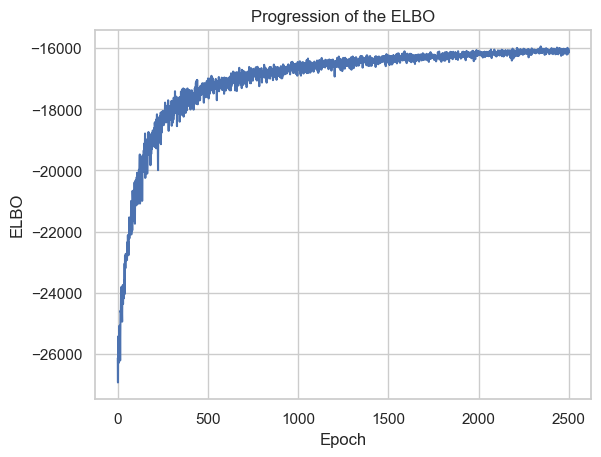

In [12]:
q.plot_elbo()

## Visualize the regression line 

In [13]:
b = q.trans_var_params["beta_smooth"]["loc"]
b

Array([17.543894, 16.963367, 16.247892, 16.104954, 15.688308, 15.634437,
       15.677285, 15.742188, 16.05522 , 16.337856, 16.55597 , 16.777208,
       17.06269 , 17.588223, 17.976448, 18.46491 , 18.990759, 19.434858,
       19.81053 , 20.331963, 20.871025, 21.3843  , 21.57169 , 21.826284,
       22.038612], dtype=float32)

In [15]:
# plot the regression line 
b = q.trans_var_params["beta_smooth"]["loc"]
x_new = jnp.linspace(df["age"].to_numpy().min(), df["age"].to_numpy().max(), num=100)
X_new = tiger.Obs(name="X_pred", intercept=False)
X_new.smooth(data = x_new, n_knots=25)
y = X_new.design_matrix @ b
#y = (X_new.design_matrix @ b)*df["bmi"].to_numpy().std() + df["bmi"].to_numpy().mean()

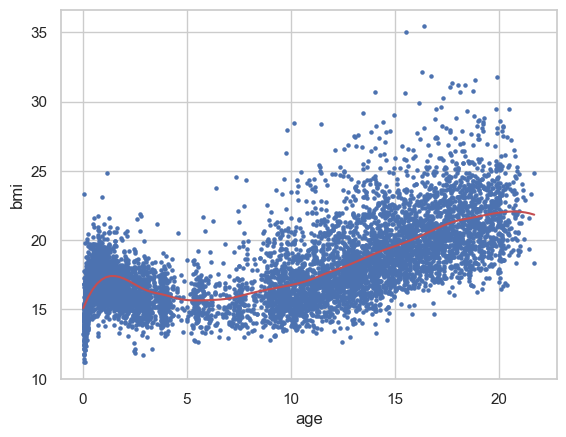

In [16]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(x_new, y, color = "r")
#ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [17]:
tau = q.trans_var_params["tau"]["loc"]
s = q.trans_var_params["tau"]["cov"]

In [18]:
tau, s

(Array([-0.57078564], dtype=float32, weak_type=True),
 Array([[0.0210028]], dtype=float32))

In [19]:
mean = jnp.exp(tau + s/2)
mean

Array([[0.5710467]], dtype=float32)

In [20]:
1 / (mean ** 2)

Array([[3.066597]], dtype=float32)

In [134]:
1 / (0.54 ** 2)

3.429355281207133